<a href="https://colab.research.google.com/github/ngonhan2k5/cs-ml/blob/master/proj1/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Load data**

In [112]:
#load data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', skipinitialspace=True, na_values="?")
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 
                     'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                     'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
#df.describe()
df.sample(4)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
16548,35,Private,112512,HS-grad,9,Widowed,Other-service,Own-child,White,Female,0,0,40,United-States,<=50K
17396,45,Private,54744,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1848,40,United-States,>50K
8227,48,State-gov,122086,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,<=50K
16463,67,Local-gov,176931,7th-8th,4,Widowed,Other-service,Not-in-family,White,Female,0,0,20,United-States,<=50K


**Clean up data**

In [113]:
#remove records missing values
no_missing_df= df.drop(df[df.native_country.isnull()].index)
no_missing_df= no_missing_df.drop(no_missing_df[no_missing_df.workclass.isnull()].index)
no_missing_df= no_missing_df.drop(no_missing_df[no_missing_df.occupation.isnull()].index)
no_missing_df.isnull().sum().max() #just checking that there's no missing data missing...

0

In [122]:
#LabelEncoder
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
no_missing_df['workclass_num']= le.fit_transform(no_missing_df['workclass'])
no_missing_df['marital_status_num']= le.fit_transform(no_missing_df['marital_status'])
no_missing_df['occupation_num']= le.fit_transform(no_missing_df['occupation'])
no_missing_df['relationship_num']= le.fit_transform(no_missing_df['relationship'])
no_missing_df['race_num']= le.fit_transform(no_missing_df['race'])
no_missing_df['sex_num']= le.fit_transform(no_missing_df['sex'])
no_missing_df['native_country_num']= le.fit_transform(no_missing_df['native_country'])
no_missing_df['income_num']= le.fit_transform(no_missing_df['income'])

#.columns

In [121]:
#remove the unnecessary features
neccessary_columns_df= no_missing_df.drop(columns=['fnlwgt', 'education', 'workclass', 'income', 'marital_status', 'occupation', 'sex', 'relationship', 'native_country', 'race'])
#neccessary_columns_df.columns

In [120]:
#separate input and target
input_df= neccessary_columns_df.drop('income_num', axis='columns')
target_df= neccessary_columns_df['income_num']

**Split data into Training and Testing**

In [119]:
#Split data into Training and Testing dataframe
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_df, target_df, test_size=0.3, random_state=0)
print("Training Data:", X_train.shape, y_train.shape)
print("Testing Data :", X_test.shape, y_test.shape)

Training Data: (21112, 12) (21112,)
Testing Data : (9049, 12) (9049,)


# 2. Training Model using Decision Tree Classifier

**Tuning Hyper-Parameter to find the best parameters**

In [124]:
from sklearn.model_selection import GridSearchCV
def get_the_GridSearcCV(model, param_dist, X, y):
  gs= GridSearchCV(model, param_dist)
  gs.fit(X, y)
  print('Tuning Hyper-Parameters:')
  print('  - The best parameters: ', gs.best_params_)
  print('  - The best score: ', gs.best_score_)
  return gs

In [203]:
#Tuning hyper-parameters by using GridSearchCV
from sklearn.tree import DecisionTreeClassifier
param_dist= {'criterion': ['gini','entropy'],
             'max_depth': [1,2,3,4,5,6,7,8,9],
             'min_samples_leaf': [2,3,4],
             'min_samples_split': [4,5,6,7,8,9]
             }
gs= get_the_GridSearcCV(DecisionTreeClassifier(), param_dist,  input_df, target_df)

Tuning Hyper-Parameters:
  - The best parameters:  {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7}
  - The best score:  0.8521602395929374


**Apply the best parameters to train the model**
*   The best parameters:  {**'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7**}
*   The best score     :  0.8521602395929374


In [205]:
best_clf= DecisionTreeClassifier(criterion= 'gini', max_depth=9, min_samples_leaf=3, min_samples_split=7)
best_clf= best_clf.fit(X_train, y_train)
score= best_clf.score(X_test, y_test)
print("Test score: ", score)

Test score:  0.8468339042988176


**The confusion matrix**
*   Apply the trained model to predict the Test set

In [208]:
#predict Testing set
y_predict= best_clf.predict(X_test)

#Show confusion matrix
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, y_predict)
confusion_df= pd.DataFrame(cm)
print("Confussion Matrix when apply the best model to the Test data")
confusion_df

Confussion Matrix when apply the best model to the Test data


,0,1
0,6490,380
1,1006,1173


In [210]:

# Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6870
           1       0.76      0.54      0.63      2179

    accuracy                           0.85      9049
   macro avg       0.81      0.74      0.77      9049
weighted avg       0.84      0.85      0.84      9049



# 3. Complexity Curve

# 4. Learning Curve

In [161]:
def show_learning_curve(train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
  train_scores_mean= np.mean(train_scores, axis=1)
  train_scores_std= np.std(train_scores, axis=1)
  test_scores_mean= np.mean(test_scores, axis=1)
  test_scores_std= np.std(test_scores, axis=1)

  plt.plot(train_sizes, train_scores_mean, label= "Training score")
  plt.plot(train_sizes, test_scores_mean, label="Cross-Validation score")

  plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color= '#DDDDDD')
  plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, color= '#DDDDDD')

  plt.title("Learning Curve")
  plt.xlabel('Training Size')
  plt.ylabel('Accuracy')
  plt.legend(loc= 'best')

**The best model**

*   Hyper-parameters= {**'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7**}



[learning_curve] Training set sizes: [  241   728  1216  1703  2191  2678  3166  3653  4141  4628  5116  5603
  6091  6578  7066  7553  8041  8528  9015  9503  9990 10478 10965 11453
 11940 12428 12915 13403 13890 14378 14865 15353 15840 16328 16815 17303
 17790 18278 18765 19253 19740 20228 20715 21203 21690 22178 22665 23153
 23640 24128]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    6.4s finished


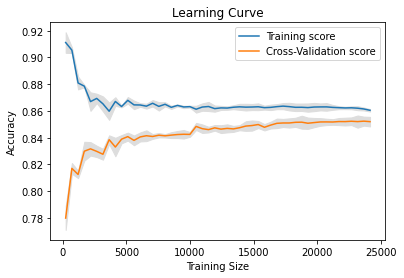

In [209]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores= learning_curve(best_clf, input_df, target_df, scoring='accuracy', train_sizes= np.linspace(0.01,1,50), verbose=1)
show_learning_curve(train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

**The other models**

**1.**   Hyper-parameters= {**'criterion': 'gini', 'max_depth': 15**}



Test score:  0.8373300917228423
[learning_curve] Training set sizes: [  241   728  1216  1703  2191  2678  3166  3653  4141  4628  5116  5603
  6091  6578  7066  7553  8041  8528  9015  9503  9990 10478 10965 11453
 11940 12428 12915 13403 13890 14378 14865 15353 15840 16328 16815 17303
 17790 18278 18765 19253 19740 20228 20715 21203 21690 22178 22665 23153
 23640 24128]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    8.8s finished


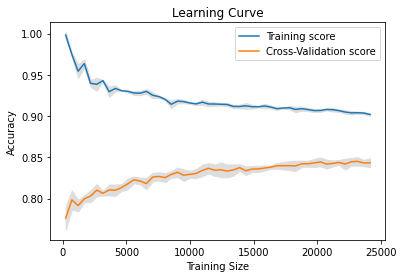

In [200]:
second_clf= DecisionTreeClassifier(criterion= 'gini', max_depth=15)
second_clf= second_clf.fit(X_train, y_train)
score= second_clf.score(X_test, y_test)
print("Test score: ", score)

train_sizes, train_scores, test_scores= learning_curve(second_clf, input_df, target_df, scoring='accuracy', train_sizes= np.linspace(0.01,1,50), verbose=1)
show_learning_curve(train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

**2.**   Hyper-parameters= {**'criterion': 'entropy'**}

Test score:  0.8127969941429992
[learning_curve] Training set sizes: [  241   728  1216  1703  2191  2678  3166  3653  4141  4628  5116  5603
  6091  6578  7066  7553  8041  8528  9015  9503  9990 10478 10965 11453
 11940 12428 12915 13403 13890 14378 14865 15353 15840 16328 16815 17303
 17790 18278 18765 19253 19740 20228 20715 21203 21690 22178 22665 23153
 23640 24128]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   11.0s finished


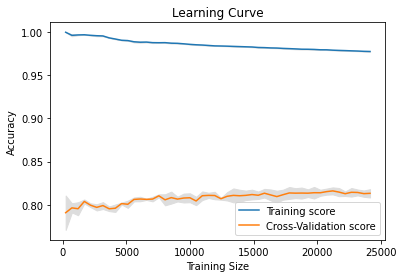

In [204]:
third_clf= DecisionTreeClassifier(criterion= 'entropy')
third_clf= third_clf.fit(X_train, y_train)
score= third_clf.score(X_test, y_test)
print("Test score: ", score)

train_sizes, train_scores, test_scores= learning_curve(third_clf, input_df, target_df, scoring='accuracy', train_sizes= np.linspace(0.01,1,50), verbose=1)
show_learning_curve(train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)